# Example 4: Zonotope Containment: Integral Zonotope Counter Example

In [1]:
import numpy as np
import pypolycontain as pp
import time
import pydrake.solvers.mathematicalprogram as MP
# use Gurobi solver
import pydrake.solvers.gurobi as Gurobi_drake
gurobi_solver=Gurobi_drake.GurobiSolver()
np.random.seed(0)

In [2]:
def alpha_necessary(Z_i,Z_o):
    alpha_min=np.inf
    V=pp.vcube(Z_i.G.shape[1])
    B=np.dot(Z_i.G,V.T)
    for i in range(V.shape[0]):
        program=MP.MathematicalProgram()
        zeta=program.NewContinuousVariables(Z_o.G.shape[1],"zeta")
        alpha=program.NewContinuousVariables(1,"alpha")
        Aeq=np.hstack(( Z_o.G, -B[:,i:i+1]))
        program.AddLinearEqualityConstraint( Aeq=np.hstack(( Z_o.G, -B[:,i:i+1])), \
                                            beq=np.zeros((Z_o.G.shape[0])),\
                                            vars= np.hstack((zeta,alpha))  )
        program.AddBoundingBoxConstraint(-1,1,zeta)
        program.AddLinearCost(-np.eye(1),np.zeros((1)),alpha)
        result=gurobi_solver.Solve(program,None,None)
        if result.is_success():
            alpha=result.GetSolution(alpha)[0]
            alpha_min=min(alpha,alpha_min)
        else:
            print("optimization failed")
    return alpha_min
        
        
def alpha_sufficient(Z_i,Z_o):
    program=MP.MathematicalProgram()
    beta=program.NewContinuousVariables(1,"beta")
    circumbody=pp.to_AH_polytope(Z_o)
    parametric_circumbody=circumbody.copy()
    parametric_circumbody.P.h=circumbody.P.h*beta
    Theta,*_=pp.subset(program,Z_i,parametric_circumbody,k=-1)
    program.AddLinearCost(np.eye(1),np.zeros((1)),beta)
    result=gurobi_solver.Solve(program,None,None)
    if result.is_success():
        alpha=1/result.GetSolution(beta)[0]
        return alpha
    else:
        print("optimization failed")

In [3]:
n=3
n_y=4
gap,i=0,0
threshold=0.1
while gap<threshold and i<500:
    G=np.random.randint(-5,6,size=(n,n_y))
    X=pp.zonotope(G=np.eye(n))
    Y=pp.zonotope(G=G,color='red')
    a_nec=alpha_necessary(X,Y)
    a_suf=alpha_sufficient(X,Y)
    gap=1-a_suf/a_nec
    i+=1
if gap>threshold:
    print("stopped at iteration: ",i)
    print('G=',G)
    print('gap=',gap)
    print('a_suf=',a_suf,'a_nec=',a_nec)
else:
    print('Could not find a counter-example')

stopped at iteration:  348
G= [[ 4 -5 -2  5]
 [ 2 -3  4 -5]
 [ 4  5  4  4]]
gap= 0.14614516357454488
a_suf= 5.3670875432457175 a_nec= 6.285714285714286


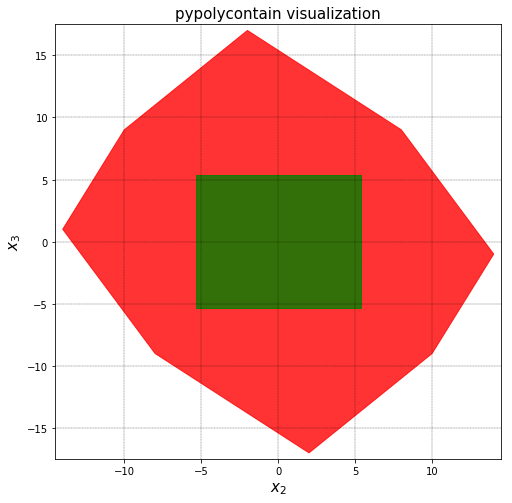

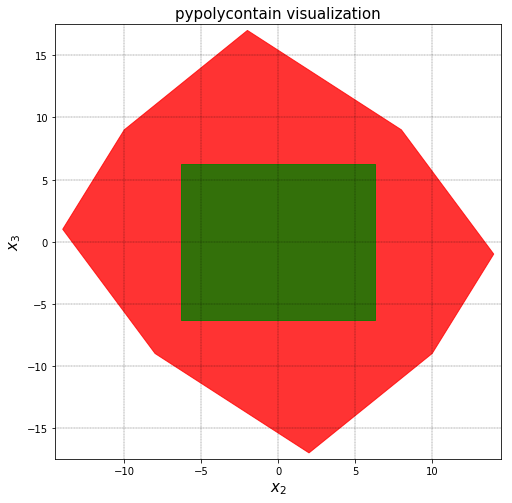

In [4]:
pp.visualize([Y,a_suf*X],tuple_of_projection_dimensions=[1,2])
pp.visualize([Y,a_nec*X],tuple_of_projection_dimensions=[1,2])